# Case Studies 2022L XAI-tabular - Homework II
### Mikołaj Piórczyński

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder

from sklearn.metrics import accuracy_score

import warnings 
warnings.filterwarnings('ignore')

## Loading data

In [2]:
df = pd.read_csv('hotel_bookings.csv')
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

## Preparing model

In [4]:
# for the simplicity we will use only subset of variables
num_features = ["lead_time", "adults", "children", "babies", "booking_changes", "previous_cancellations", "is_repeated_guest"]
cat_features = ["arrival_date_month", "deposit_type", "customer_type"]

features = num_features + cat_features

In [5]:
# separate features and target
X = df.drop(["is_canceled"], axis=1)[features]
y = df["is_canceled"]

In [6]:
num_transformer = SimpleImputer(strategy="mean")

cat_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OrdinalEncoder())])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_features),
        ("cat", cat_transformer, cat_features)
    ]
)

In [7]:
rf_model = RandomForestClassifier(
    n_estimators=160,
    max_features=0.4,
    min_samples_split=2,
    n_jobs=-1,
    random_state=0
)

In [8]:
# prepare model pipeline
model_pipe = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('model', rf_model)
    ]
)

In [9]:
# split data into train and test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=123)

In [10]:
# train model 
model_pipe.fit(X_train, y_train)
preds = model_pipe.predict(X_test)
score = accuracy_score(y_test, preds)
print(f"Accuracy score: {round(score, 4)}")

Accuracy score: 0.7742


## Explaining model

### Selecting observation

Let's select the observation for which model prediction will be explained. 

In [12]:
idx1 = 3223
observation1 = X_test.loc[[idx1]]
prediction1 = model_pipe.predict(observation1)
print(f'Predicted value for the selected observation: {prediction1[0]}, real value: {y_test.loc[idx1]}')

Predicted value for the selected observation: 0, real value: 0


In [13]:
observation1.squeeze()

lead_time                              15
adults                                  2
children                              0.0
babies                                  1
booking_changes                         3
previous_cancellations                  0
is_repeated_guest                       0
arrival_date_month               November
deposit_type                   No Deposit
customer_type             Transient-Party
Name: 3223, dtype: object

## LIME (Local Interpretable Model-agnostic Explanations)

Let's create LIME explainer.

In [14]:
from lime.lime_tabular import LimeTabularExplainer

explainer = LimeTabularExplainer(
    model_pipe['preprocessor'].transform(X_train), feature_names=X_train.columns.tolist(), 
    categorical_features=np.where(X_train.columns.isin(cat_features))[0].tolist(),
    discretize_continuous=False
)

In [15]:
predict_fn = lambda x: model_pipe['model'].predict_proba(x)

### Calculating the model prediction decomposition using LIME

In [16]:
exp1 = explainer.explain_instance(model_pipe['preprocessor'].transform(observation1).ravel(), predict_fn)

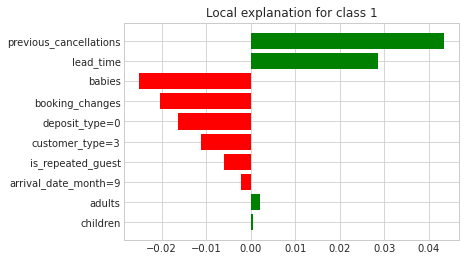

In [17]:
with plt.style.context("seaborn-whitegrid"):
    exp1.as_pyplot_figure()

Let's define helper function, which selects observation from the dataset, makes a prediction and prepares an explanation. 

In [18]:
# all in one function
def create_explanation(idx):
    observation = X_test.loc[[idx]]
    print(observation.squeeze())
    prediction = model_pipe.predict(observation)
    print(f'\nPredicted value for the selected observation: {prediction[0]}, real value: {y_test.loc[idx]}')
    
    exp = explainer.explain_instance(model_pipe['preprocessor'].transform(observation).ravel(), predict_fn)
    with plt.style.context("seaborn-whitegrid"):
        exp.as_pyplot_figure()

lead_time                              15
adults                                  2
children                              0.0
babies                                  1
booking_changes                         3
previous_cancellations                  0
is_repeated_guest                       0
arrival_date_month               November
deposit_type                   No Deposit
customer_type             Transient-Party
Name: 3223, dtype: object

Predicted value for the selected observation: 0, real value: 0


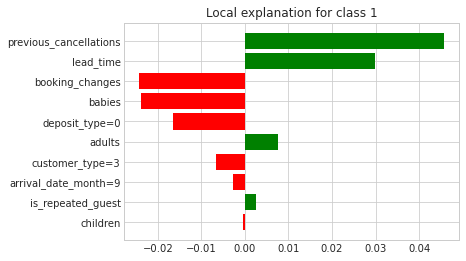

In [25]:
create_explanation(idx1)

### Comparing LIME decomposition for different observations in the set

Let's use the k-nearest neighbours algorithm to calculate model prediction decomposition for k-nearest observations in dataset to check stabililty of received explanations.

In [26]:
class KNNPipeline(Pipeline):    
    def fit(self, X_train, X_test):
        self['preprocessor'].fit(X_train)
        self['model'].fit(self['preprocessor'].transform(X_test))
        return self
    
    def predict(self, x, **kwargs):
        return self['model'].kneighbors(self['preprocessor'].transform(x), **kwargs)

In [27]:
from sklearn.neighbors import NearestNeighbors

knn_pipe = KNNPipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('model', NearestNeighbors(n_neighbors=4))
    ]
)

knn_pipe.fit(X_train, X_test);

Let's find nearest observations in the dataset for our selected observation no. 3223.

In [28]:
obsevation1_knn = X_test.iloc[knn_pipe.predict(observation1, return_distance=False).ravel().tolist()[1:]]
obsevation1_knn

,lead_time,adults,children,babies,booking_changes,previous_cancellations,is_repeated_guest,arrival_date_month,deposit_type,customer_type
18777,15,2,0.0,1,2,0,0,November,No Deposit,Transient
100962,15,2,0.0,0,2,0,0,November,No Deposit,Transient
3206,15,2,2.0,0,3,0,0,November,No Deposit,Transient-Party


lead_time                         15
adults                             2
children                         0.0
babies                             1
booking_changes                    2
previous_cancellations             0
is_repeated_guest                  0
arrival_date_month          November
deposit_type              No Deposit
customer_type              Transient
Name: 18777, dtype: object

Predicted value for the selected observation: 0, real value: 0
lead_time                         15
adults                             2
children                         0.0
babies                             0
booking_changes                    2
previous_cancellations             0
is_repeated_guest                  0
arrival_date_month          November
deposit_type              No Deposit
customer_type              Transient
Name: 100962, dtype: object

Predicted value for the selected observation: 1, real value: 0
lead_time                              15
adults                             

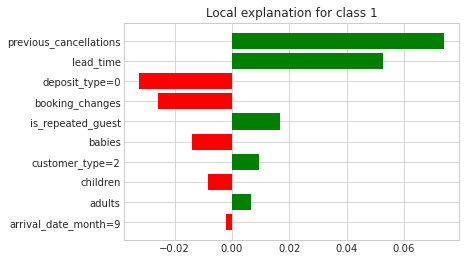

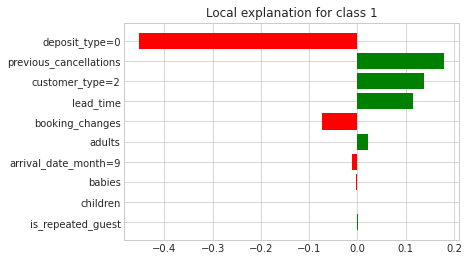

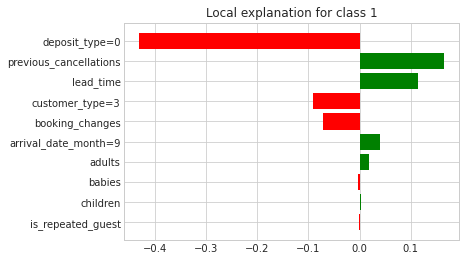

In [29]:
for idx in obsevation1_knn.index:
    create_explanation(idx)

## Comment

Obtained explanations seem to be stable. (as far as I know in general LIME explanations aren’t robust and while making predictions on similar points we should have get similar results and similar exlpanations, but with LIME it's not always satisfied, nevertheless in this case for samples that I've choosen it seems to be satisfied). We can see that the biggest negative contribution nearly in all cases have `deposite_type` and `booking_changes` and positive `previous_cancelations` and `lead_time`. Despite of this stability model and/or explanations in my opinion seem to be untrusthworthy. It's counterintuitive that the fact that in past someone didn't make any cancellations or relatively short period between booking and arrival/cancellation date makes that it's more likely that booking will be cancelled. But there are also some 'common-sense; explanations like the fact that someone is not repeated guest makes cancellation more probable. It's worth noting that in case of second nearest observation model predicts cancellation despite there is a little difference in values of variables compared to base observation. It's suggests that model is not perfect (what we also could say only looking on obtained accuracy on test set, which is quite poor). What really puzzles me is why in case of base and first similar obseravtions contributions of variables are an order of magnitude smaller than in other cases.